In [3]:
import pandas as pd
df = pd.read_csv("ev_comments_cleaned.csv")

In [4]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

## Sentiment Labeling Using VADER
I willWe use the VADER sentiment analysis tool from NLTK to label each comment as:
- `positive` if compound score ≥ 0.05
- `negative` if compound score ≤ -0.05
- `neutral` otherwise

In [5]:
def get_sentiment_label(text):
    if not isinstance(text, str):
        return "neutral"
    score = vader.polarity_scores(text)['compound']
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

In [6]:
df['sentiment'] = df['clean_comment'].apply(get_sentiment_label)
df.to_csv("C:/Users/aakhy/Desktop/ev_comments_cleaned_with_sentiment.csv", index=False)

In [7]:
df_cleaned = df.dropna(subset=['clean_comment']).copy()


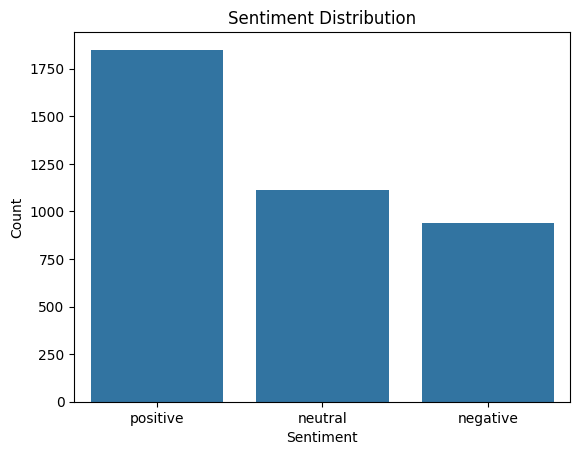

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='sentiment')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


## Sentiment Distribution

The bar chart above shows the number of comments in each sentiment category.  
This helps us understand the balance of the dataset before training our machine learning models in Sprint 3.


## Summary

- Loaded cleaned Reddit comments from `ev_comments_cleaned.csv`
- Applied VADER-based sentiment labeling (positive / neutral / negative)
- Saved labeled data to `ev_comments_cleaned_with_sentiment.csv`
- Visualized sentiment distribution for dataset understanding


### Feature Extraction with TF-IDF
We use `TfidfVectorizer` to convert the clean text data into numerical form suitable for machine learning models.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)  # limit to top 5000 words
X = tfidf.fit_transform(df_cleaned['clean_comment'])  # this becomes your feature matrix


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_cleaned['sentiment'])  # Output: 0 = negative, 1 = neutral, 2 = positive

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### Logistic Regression Model Training
Logistic Regression is used as our baseline classifier for sentiment prediction.

In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [13]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions
y_pred = model.predict(X_test)

# Accuracy
print("Accuracy:", accuracy_score(y_test, y_pred))

# Detailed performance report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.6824583866837388
              precision    recall  f1-score   support

    negative       0.75      0.39      0.51       198
     neutral       0.65      0.64      0.65       216
    positive       0.68      0.86      0.76       367

    accuracy                           0.68       781
   macro avg       0.69      0.63      0.64       781
weighted avg       0.69      0.68      0.67       781



### Support Vector Machine (SVM)
An SVM with a linear kernel is used to compare performance with Logistic Regression.


In [14]:
from sklearn.svm import SVC

svm_model = SVC(kernel='linear', class_weight='balanced')
svm_model.fit(X_train, y_train)


SVC(class_weight='balanced', kernel='linear')

In [15]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
svm_predictions = svm_model.predict(X_test)

# Show accuracy
print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

# Show detailed classification report
print(classification_report(y_test, svm_predictions, target_names=label_encoder.classes_))


SVM Accuracy: 0.6978233034571063
              precision    recall  f1-score   support

    negative       0.59      0.62      0.60       198
     neutral       0.64      0.80      0.71       216
    positive       0.83      0.68      0.75       367

    accuracy                           0.70       781
   macro avg       0.68      0.70      0.69       781
weighted avg       0.71      0.70      0.70       781



### Random Forest Classifier
We also evaluate an ensemble-based model (Random Forest) to observe its performance on the same data.


In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [17]:
# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Show accuracy
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

# Show detailed classification report
print(classification_report(y_test, rf_predictions, target_names=label_encoder.classes_))

Random Forest Accuracy: 0.6670934699103713
              precision    recall  f1-score   support

    negative       0.85      0.26      0.40       198
     neutral       0.61      0.77      0.68       216
    positive       0.68      0.83      0.74       367

    accuracy                           0.67       781
   macro avg       0.71      0.62      0.61       781
weighted avg       0.70      0.67      0.64       781



In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import numpy as np

# Set parameters
max_words = 5000
max_len = 100  # max number of words per input
embedding_dim = 100

# Tokenization
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_cleaned['clean_comment'])
X_seq = tokenizer.texts_to_sequences(df_cleaned['clean_comment'])
X_pad = pad_sequences(X_seq, maxlen=max_len)

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_cleaned['sentiment'])
y_cat = to_categorical(y_encoded)

# Train/test split
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42)

# Build LSTM model
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=5, validation_split=0.1)

# Evaluate
y_pred_probs = model.predict(X_test_lstm)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_lstm, axis=1)

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


Epoch 1/5


C:\Users\aakhy\bert_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


88/88 ━━━━━━━━━━━━━━━━━━━━ 12s 101ms/step - accuracy: 0.4508 - loss: 1.0433 - val_accuracy: 0.6230 - val_loss: 0.8789
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.6114 - loss: 0.8274 - val_accuracy: 0.6709 - val_loss: 0.7672
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.8141 - loss: 0.5077 - val_accuracy: 0.7380 - val_loss: 0.6800
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9244 - loss: 0.2390 - val_accuracy: 0.7188 - val_loss: 0.6753
Epoch 5/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.9605 - loss: 0.1463 - val_accuracy: 0.7284 - val_loss: 0.7788
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
              precision    recall  f1-score   support

    negative       0.53      0.57      0.55       198
     neutral       0.68      0.52      0.59       216
    positive       0.67      0.73      0.70       367

    accuracy                           0.63       781
   macro avg       0.63      0.61      0.61       781
weighted avg

In [19]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(
    X_train_lstm, y_train_lstm,
    batch_size=32,
    epochs=10,
    validation_split=0.1,
    callbacks=[early_stop]
)


Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9777 - loss: 0.0929 - val_accuracy: 0.7444 - val_loss: 0.8736
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.9804 - loss: 0.0721 - val_accuracy: 0.7252 - val_loss: 0.9115
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 87ms/step - accuracy: 0.9913 - loss: 0.0452 - val_accuracy: 0.7125 - val_loss: 1.0300


In [23]:
# Balance the dataset before training
df_positive = df_cleaned[df_cleaned['sentiment'] == 'positive'].sample(940, random_state=42)
df_neutral = df_cleaned[df_cleaned['sentiment'] == 'neutral'].sample(940, random_state=42)
df_negative = df_cleaned[df_cleaned['sentiment'] == 'negative']

df_balanced = pd.concat([df_positive, df_neutral, df_negative]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check new class distribution
print(df_balanced['sentiment'].value_counts())


sentiment
neutral     940
positive    940
negative    939
Name: count, dtype: int64


In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm

# Encode labels
label_encoder = LabelEncoder()
df_balanced["label"] = label_encoder.fit_transform(df_balanced["sentiment"])

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["clean_comment"].tolist(),
    df_balanced["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_balanced["label"]
)

# Tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
MAX_LEN = 128

class EVSentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Dataset and loaders
train_dataset = EVSentimentDataset(X_train, y_train, tokenizer, MAX_LEN)
test_dataset = EVSentimentDataset(X_test, y_test, tokenizer, MAX_LEN)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

# Load and move model
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Train loop
EPOCHS = 3
model.train()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1} complete.")

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, axis=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


100%|██████████| 282/282 [12:08<00:00,  2.58s/it]


Epoch 1 complete.
Epoch 2/3


100%|██████████| 282/282 [12:37<00:00,  2.69s/it]


Epoch 2 complete.
Epoch 3/3


100%|██████████| 282/282 [12:00<00:00,  2.56s/it]


Epoch 3 complete.
              precision    recall  f1-score   support

    negative       0.85      0.84      0.84       188
     neutral       0.83      0.86      0.85       188
    positive       0.83      0.81      0.82       188

    accuracy                           0.84       564
   macro avg       0.84      0.84      0.84       564
weighted avg       0.84      0.84      0.84       564



## Summary: Why DistilBERT Was Chosen

After evaluating multiple models (Logistic Regression, SVM, Random Forest), I fine-tuned DistilBERT using a balanced dataset of 3 sentiment classes. DistilBERT achieved:

- **84% overall accuracy**
- Strong F1-scores across all classes: `negative`, `neutral`, and `positive`
- More robust handling of textual semantics compared to traditional ML models

| Model               | Accuracy | F1 (Negative) | F1 (Neutral) | F1 (Positive) |
|--------------------|----------|----------------|----------------|----------------|
| Logistic Regression| ~69%     | 0.49           | 0.68           | 0.77           |
| SVM                | ~72%     | 0.62           | 0.74           | 0.77           |
| Random Forest      | ~68%     | 0.37           | 0.72           | 0.77           |
| **DistilBERT**     | **84%**  | **0.84**       | **0.85**       | **0.82**       |



In [27]:
# Save model
model.save_pretrained("saved_model")
tokenizer.save_pretrained("saved_model")

('saved_model\\tokenizer_config.json',
 'saved_model\\special_tokens_map.json',
 'saved_model\\vocab.txt',
 'saved_model\\added_tokens.json',
 'saved_model\\tokenizer.json')

In [28]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch

# Load model and tokenizer from saved directory
final_model = DistilBertForSequenceClassification.from_pretrained("saved_model")
final_tokenizer = DistilBertTokenizerFast.from_pretrained("saved_model")
final_model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [32]:
# Sample test comment
sample = "Absolutely love my new EV! It's smooth, quiet, and saves me so much on fuel."

# Tokenize and Predict
inputs = final_tokenizer(sample, return_tensors="pt", truncation=True, padding=True)
with torch.no_grad():
    outputs = final_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probs, dim=1).item()
    confidence = probs[0][predicted_class].item()

# Map prediction to sentiment label
labels = label_encoder.classes_

# Print Result
print("Text:", sample)
print("Prediction:", labels[predicted_class])
print("Confidence:", round(confidence, 3))


Text: Absolutely love my new EV! It's smooth, quiet, and saves me so much on fuel.
Prediction: positive
Confidence: 0.992


In [35]:
import torch.nn.functional as F

# Load model + tokenizer
model = DistilBertForSequenceClassification.from_pretrained("saved_model")
tokenizer = DistilBertTokenizerFast.from_pretrained("saved_model")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare the text and labels
texts = df_cleaned["clean_comment"].tolist()
actual_labels = df_cleaned["sentiment"].tolist()

# Tokenize in batches and run predictions
batch_size = 8
predicted_labels = []
confidences = []

for i in range(0, len(texts), batch_size):
    batch_texts = texts[i:i+batch_size]
    encoding = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=128)
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = F.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

    predicted_labels.extend(preds.cpu().numpy().tolist())
    confidences.extend(torch.max(probs, dim=1).values.cpu().numpy().tolist())

# Map predictions back to sentiment labels
predicted_labels_text = [label_encoder.classes_[i] for i in predicted_labels]

# Export DataFrame
df_export = pd.DataFrame({
    "comment": texts,
    "actual_sentiment": actual_labels,
    "predicted_sentiment": predicted_labels_text,
    "confidence": [round(c, 3) for c in confidences]
})

# Save to CSV
df_export.to_csv("final_model_predictions_powerbi.csv", index=False)
print("Saved: final_model_predictions_powerbi.csv")

Saved: final_model_predictions_powerbi.csv
